# Evaluating the Impact of Data Augmentation and Transfer Learning on Plant Leaf Disease Classification

### Author
Ivan Chiari  

### Objective
This notebook presents a controlled experimental study to evaluate how data augmentation and transfer learning affect the performance of convolutional neural networks in classifying plant leaf diseases using a public dataset.

## 1. Problem Statement

Despite the increasing use of deep learning for plant disease recognition, many existing studies emphasize achieving high classification accuracy while paying limited attention to the methodological impact of data augmentation and transfer learning under controlled experimental conditions. In practical applications, especially for small- to medium-scale datasets, the choice of training strategy—such as whether to apply data augmentation or to rely on pretrained models—can significantly influence model performance and generalization. However, there is a lack of clear experimental evidence that isolates and compares these strategies using consistent training settings. This study addresses this gap by systematically evaluating the effects of data augmentation and transfer learning on plant leaf disease classification using a publicly available dataset, with all other training factors held constant.

## 2. Research Objectives

### Primary Objective
To evaluate the impact of data augmentation and transfer learning on the performance of convolutional neural networks for plant leaf disease classification under controlled experimental conditions.

### Specific Objectives
1. To establish a baseline performance using a simple CNN model trained without data augmentation.  
2. To measure the effect of data augmentation on classification performance using the same CNN architecture and training configuration.  
3. To assess the additional contribution of transfer learning by comparing a pretrained lightweight model with the augmented CNN baseline.  
4. To analyze model performance using macro-averaged F1-score and weighted loss to address class imbalance.  
5. To provide a reproducible experimental framework for training and evaluating image-based plant disease classifiers.

## 3. Method Overview

This study follows a controlled experimental design consisting of three training configurations:

- Baseline CNN without data augmentation  
- CNN with data augmentation  
- Pretrained MobileNetV2 with data augmentation  

All experiments use the same dataset split, optimizer, learning rate, batch size, and number of epochs to ensure fair comparison. Performance is evaluated primarily using macro-averaged F1-score, with accuracy reported as a secondary metric.



In [1]:
## Libraries and Tools

# This project is implemented using the following libraries:

# - NumPy for numerical computation
# - TensorFlow and Keras for model development and training
# - scikit-learn for evaluation metrics and class imbalance handling
# - Matplotlib for result visualization
# - Seaborn for confusion matrix visualization

import numpy as np
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import tensorflow as tf
tf.config.list_physical_devices('GPU')



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# dataset
# PlantVillage dataset :https://www.kaggle.com/datasets/emmarex/plantdisease

!pip install -q kaggle
import os

os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)
!kaggle datasets download -d emmarex/plantdisease
!unzip plantdisease.zip -d plant_disease


Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating

In [5]:
# Check Class and image number

DATA_DIR = "/content/PlantVillage"

classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
num_classes = len(classes)

print(f"Number of classes: {num_classes}")


Number of classes: 15


In [6]:
from collections import defaultdict

class_counts = defaultdict(int)

for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    images = os.listdir(cls_path)
    class_counts[cls] = len(images)

# Show summary
for cls, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"CLass {cls} have  {count} images")


CLass Tomato__Tomato_YellowLeaf__Curl_Virus have  3209 images
CLass Tomato_Bacterial_spot have  2127 images
CLass Tomato_Late_blight have  1909 images
CLass Tomato_Septoria_leaf_spot have  1771 images
CLass Tomato_Spider_mites_Two_spotted_spider_mite have  1676 images
CLass Tomato_healthy have  1591 images
CLass Pepper__bell___healthy have  1478 images
CLass Tomato__Target_Spot have  1404 images
CLass Potato___Late_blight have  1000 images
CLass Tomato_Early_blight have  1000 images
CLass Potato___Early_blight have  1000 images
CLass Pepper__bell___Bacterial_spot have  997 images
CLass Tomato_Leaf_Mold have  952 images
CLass Tomato__Tomato_mosaic_virus have  373 images
CLass Potato___healthy have  152 images


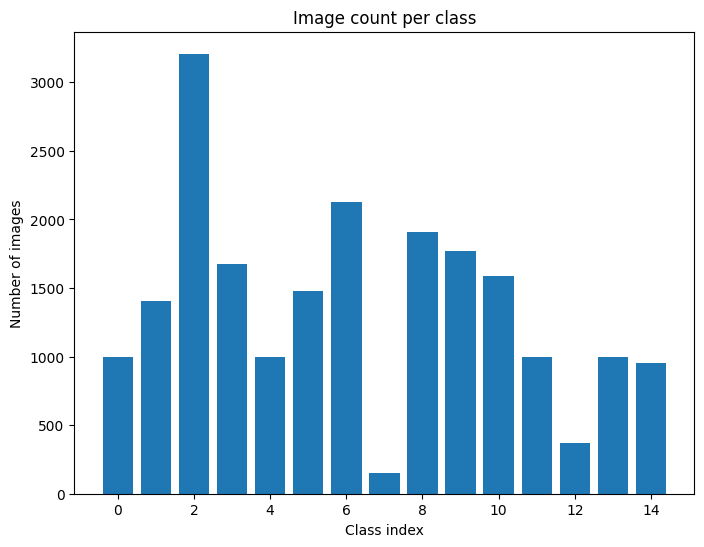

In [7]:
# plot the class distribution

plt.figure(figsize=(8, 6))
plt.bar(range(len(class_counts)), class_counts.values())
plt.xlabel("Class index")
plt.ylabel("Number of images")
plt.title("Image count per class")
plt.show()


## Class Imbalance Analysis and Handling Strategy

An inspection of the dataset reveals a substantial imbalance in the number of images across classes. The largest class (Tomato Yellow Leaf Curl Virus) contains more than 3,200 images, while the smallest class (Potato healthy) contains only 152 images. This represents a class distribution ratio of over 20:1, indicating a severe imbalance problem.

Such imbalance can negatively affect model training, as standard loss functions tend to bias learning toward majority classes. As a result, a model trained without corrective measures may achieve high overall accuracy while performing poorly on underrepresented disease categories.

To address this issue, this study adopts a weighted loss strategy, where higher loss weights are assigned to minority classes. This approach ensures that misclassifications of rare classes contribute more significantly to the optimization process, encouraging the model to learn discriminative features for all classes rather than only the most frequent ones.

In addition to weighted loss, macro-averaged F1-score is selected as the primary evaluation metric. Unlike accuracy, which is dominated by majority classes, macro-F1 treats each class equally by averaging performance across all categories. This metric provides a more reliable assessment of model effectiveness in the presen


## Dataset Classes

The dataset used in this experiment distributed across **15 plant disease classes**.
Each class corresponds to a specific plant–disease condition.

### List of classes

| ID | Class name                                  |
| -- | ------------------------------------------- |
| 0  | Pepper__bell___Bacterial_spot               |
| 1  | Pepper__bell___healthy                      |
| 2  | Potato___Early_blight                       |
| 3  | Potato___Late_blight                        |
| 4  | Potato___healthy                            |
| 5  | Tomato_Bacterial_spot                       |
| 6  | Tomato_Early_blight                         |
| 7  | Tomato_Late_blight                          |
| 8  | Tomato_Leaf_Mold                            |
| 9  | Tomato_Septoria_leaf_spot                   |
| 10 | Tomato_Spider_mites_Two_spotted_spider_mite |
| 11 | Tomato__Target_Spot                         |
| 12 | Tomato__Tomato_YellowLeaf__Curl_Virus       |
| 13 | Tomato__Tomato_mosaic_virus                 |
| 14 | Tomato_healthy                              |



## Data Preparation
- Split dataset into 70% train 15% test and 15% val

In [8]:
import shutil
import random

SOURCE_DIR = "/content/PlantVillage"
TARGET_DIR = "/content/data_split"

TRAIN_RATIO = 0.7
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

random.seed(42)

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(TARGET_DIR, split), exist_ok=True)

classes = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]

for cls in classes:
    cls_path = os.path.join(SOURCE_DIR, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * TRAIN_RATIO)
    n_val   = int(n_total * VAL_RATIO)

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train + n_val]
    test_imgs  = images[n_train + n_val:]

    for split_name, split_imgs in zip(
        ["train", "val", "test"],
        [train_imgs, val_imgs, test_imgs]
    ):
        split_cls_dir = os.path.join(TARGET_DIR, split_name, cls)
        os.makedirs(split_cls_dir, exist_ok=True)
        print(f"Copying {len(split_imgs)} images to {split_cls_dir}...")

        for img in split_imgs:
            shutil.copy(os.path.join(cls_path, img),
                        os.path.join(split_cls_dir, img))

print("Dataset split completed.")


Copying 700 images to /content/data_split/train/Potato___Late_blight...
Copying 150 images to /content/data_split/val/Potato___Late_blight...
Copying 150 images to /content/data_split/test/Potato___Late_blight...
Copying 982 images to /content/data_split/train/Tomato__Target_Spot...
Copying 210 images to /content/data_split/val/Tomato__Target_Spot...
Copying 212 images to /content/data_split/test/Tomato__Target_Spot...
Copying 2246 images to /content/data_split/train/Tomato__Tomato_YellowLeaf__Curl_Virus...
Copying 481 images to /content/data_split/val/Tomato__Tomato_YellowLeaf__Curl_Virus...
Copying 482 images to /content/data_split/test/Tomato__Tomato_YellowLeaf__Curl_Virus...
Copying 1173 images to /content/data_split/train/Tomato_Spider_mites_Two_spotted_spider_mite...
Copying 251 images to /content/data_split/val/Tomato_Spider_mites_Two_spotted_spider_mite...
Copying 252 images to /content/data_split/test/Tomato_Spider_mites_Two_spotted_spider_mite...
Copying 700 images to /conten

## Dataset Preparation Strategy

To ensure clean, reproducible experiments, the dataset loading and preprocessing steps are implemented through a single reusable function. This design allows consistent handling of normalization, batching, and shuffling across all dataset splits, while enabling data augmentation to be applied selectively only to the training set.

Augmentation is controlled through a parameter in the dataset creation function. This approach avoids code duplication, reduces the risk of inconsistent preprocessing between experiments, and ensures that validation and test sets remain unaltered to preserve the integrity of model evaluation.


In [9]:
# Load Dataset
# Each dataset is resize to 224 X 224 pxl and Batchsize 32
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Normalization layer
normalization = tf.keras.layers.Rescaling(1./255)

# Augmentation pipeline (moderate)
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

def create_dataset(path, augment=False, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

    def preprocess(x, y):
        x = normalization(x)
        if augment:
            x = augmentation(x, training=True)
        return x, y

    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds



In [10]:
# Load the dataset
train_plain = create_dataset("/content/data_split/train", augment=False)
train_aug   = create_dataset("/content/data_split/train", augment=True)

val_ds  = create_dataset("/content/data_split/val", augment=False, shuffle=False)
test_ds = create_dataset("/content/data_split/test", augment=False, shuffle=False)



Found 14440 files belonging to 15 classes.
Found 14440 files belonging to 15 classes.
Found 3089 files belonging to 15 classes.
Found 3109 files belonging to 15 classes.


In [11]:
print(f"Number of classes: {len(classes)}")
print(f"Train plain dataset batches: {len(train_plain)}")
print(f"Train augmented dataset batches: {len(train_aug)}")
print(f"Validation dataset batches: {len(val_ds)}")
print(f"Test dataset batches: {len(test_ds)}")

Number of classes: 15
Train plain dataset batches: 452
Train augmented dataset batches: 452
Validation dataset batches: 97
Test dataset batches: 98


Let's inspect the shape and data type of one batch from the `train_plain` dataset:

In [12]:
for image_batch, label_batch in train_plain.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Image batch data type: {image_batch.dtype}")
    print(f"Label batch data type: {label_batch.dtype}")
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Image batch data type: <dtype: 'float32'>
Label batch data type: <dtype: 'int32'>


## Experiment

All experiments are conducted under the same training configuration to ensure fair comparison across models. The following settings are fixed for all runs:

- Input image size: 224 × 224 × 3  
- Batch size: 32  
- Optimizer: Adam  
- Loss function: Sparse Categorical Crossentropy  
- Evaluation metrics: Accuracy (training), Macro F1 (post-training)  
- Class imbalance handling: class-weighted loss  
- Hardware: Google Colab GPU (when available)  

Only the model architecture and data augmentation strategy are varied between experiments.


In [13]:
def train_model(model, train_ds, val_ds, class_weights, epochs=20):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weights
    )
    return history


## Baseline CNN Model: Experimental Justification

The `build_basic_cnn` function defines the architecture for our **Baseline CNN model**. This model serves as the foundational component of our experimental design, directly addressing the first specific objective: *"To establish a baseline performance using a simple CNN model trained without data augmentation."*

This CNN is intentionally kept relatively simple, consisting of a few convolutional layers, max-pooling layers, a flatten layer, and dense layers with dropout. By training this model on the dataset *without any data augmentation* and *without transfer learning*, its performance provides a crucial benchmark against which the effects of data augmentation and transfer learning can be isolated and measured. This controlled setup ensures that any improvements observed in subsequent experiments can be attributed directly to the applied techniques, fulfilling the controlled experimental conditions outlined in the problem statement.

In [14]:
def build_basic_cnn(num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(224,224,3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    return model


## MobileNetV2

MobileNetV2 is employed in this study to specifically assess the impact of **transfer learning** on plant leaf disease classification. As outlined in the research objectives, one primary goal is to evaluate the additional contribution of pretrained models. MobileNetV2, being a lightweight yet powerful convolutional neural network pretrained on the extensive ImageNet dataset, serves as an excellent candidate for this purpose.

By comparing its performance (after fine-tuning a classification head) against the baseline CNN and the augmented CNN, we can quantitatively measure the benefits of leveraging rich feature representations learned from a large-scale, diverse dataset for our specific task. This controlled comparison allows us to isolate the effectiveness of transfer learning as a strategy for improving model performance and generalization, particularly with potentially limited or imbalanced datasets common in agricultural applications.

In [15]:
def build_mobilenetv2(num_classes, trainable=False):
    base_model = tf.keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(224,224,3)
    )
    base_model.trainable = trainable  # freeze for now

    inputs = tf.keras.Input(shape=(224,224,3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    return model


## Handling Class Imbalance

The dataset exhibits a clear class imbalance across plant disease categories. To mitigate bias toward majority classes without modifying the original data distribution, class-weighted loss is employed.

Class weights are computed from the training set using an inverse-frequency scheme, ensuring that minority classes contribute more strongly to the total loss during optimization. The same class weights are applied consistently across all experiments to maintain controlled and fair comparisons.


In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# get labels from training dataset
train_labels = []

for _, labels in train_plain.unbatch():
    train_labels.append(labels.numpy())

train_labels = np.array(train_labels)

class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = {
    i: w for i, w in enumerate(class_weights_array)
}

class_weights


{0: np.float64(1.3811573409851745),
 1: np.float64(0.9310122501611864),
 2: np.float64(1.3752380952380951),
 3: np.float64(1.3752380952380951),
 4: np.float64(9.081761006289309),
 5: np.float64(0.6469534050179212),
 6: np.float64(1.3752380952380951),
 7: np.float64(0.720558882235529),
 8: np.float64(1.4454454454454455),
 9: np.float64(0.77697067527576),
 10: np.float64(0.8206876953680022),
 11: np.float64(0.9803122878479293),
 12: np.float64(0.4288047512991834),
 13: np.float64(3.6883780332056193),
 14: np.float64(0.8649296196466008)}

## Interpretation of Class Weights

The computed class weights reveal substantial imbalance in the dataset. While most classes receive weights close to 1, indicating moderate representation, several minority classes exhibit significantly higher weights (e.g., class 4 with a weight above 9.0).

This confirms that without corrective measures, the training process would be biased toward majority classes. By incorporating these weights into the loss function, the model is encouraged to treat misclassification of underrepresented disease categories as more costly, thereby improving fairness across all classes.


In [17]:
cnn_clean = build_basic_cnn(num_classes=15)
history_cnn_clean = train_model(
    cnn_clean,
    train_plain,
    val_ds,
    class_weights,
    epochs=20
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 45s 78ms/step - accuracy: 0.2864 - loss: 2.3111 - val_accuracy: 0.7562 - val_loss: 0.7952
Epoch 2/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.6848 - loss: 0.9901 - val_accuracy: 0.7523 - val_loss: 0.7421
Epoch 3/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.7904 - loss: 0.6297 - val_accuracy: 0.8495 - val_loss: 0.4789
Epoch 4/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.8555 - loss: 0.4325 - val_accuracy: 0.8572 - val_loss: 0.4221
Epoch 5/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.8862 - loss: 0.3218 - val_accuracy: 0.8673 - val_loss: 0.4024
Epoch 6/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.9134 - loss: 0.2494 - val_accuracy: 0.8734 - val_loss: 0.4056
Epoch 7/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.9167 - loss: 0.2292 - val_accuracy: 0.8754 - val_loss: 0.4139
Epoch 8/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.9300 - loss: 0.2000 - 

In [18]:
cnn_aug = build_basic_cnn(num_classes=15)
history_cnn_aug = train_model(
    cnn_aug,
    train_aug,
    val_ds,
    class_weights,
    epochs=20
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 138s 291ms/step - accuracy: 0.2387 - loss: 2.4958 - val_accuracy: 0.6507 - val_loss: 1.0319
Epoch 2/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 138s 294ms/step - accuracy: 0.5941 - loss: 1.2772 - val_accuracy: 0.7637 - val_loss: 0.7279
Epoch 3/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 131s 289ms/step - accuracy: 0.6901 - loss: 0.9604 - val_accuracy: 0.7961 - val_loss: 0.6341
Epoch 4/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 131s 288ms/step - accuracy: 0.7461 - loss: 0.7595 - val_accuracy: 0.7999 - val_loss: 0.6535
Epoch 5/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 133s 292ms/step - accuracy: 0.7630 - loss: 0.7194 - val_accuracy: 0.7967 - val_loss: 0.6233
Epoch 6/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 141s 290ms/step - accuracy: 0.8068 - loss: 0.5617 - val_accuracy: 0.8537 - val_loss: 0.4570
Epoch 7/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 142s 289ms/step - accuracy: 0.8182 - loss: 0.5448 - val_accuracy: 0.8239 - val_loss: 0.5463
Epoch 8/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 129s 285ms/step - accuracy: 0.8421 - loss: 0.44

In [19]:
mobilenet_aug = build_mobilenetv2(num_classes=15, trainable=False)
history_mobilenet = train_model(
    mobilenet_aug,
    train_aug,
    val_ds,
    class_weights,
    epochs=20
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 172s 339ms/step - accuracy: 0.5463 - loss: 1.4513 - val_accuracy: 0.8530 - val_loss: 0.4779
Epoch 2/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 131s 289ms/step - accuracy: 0.7919 - loss: 0.5978 - val_accuracy: 0.8475 - val_loss: 0.4432
Epoch 3/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 132s 290ms/step - accuracy: 0.8283 - loss: 0.4975 - val_accuracy: 0.8757 - val_loss: 0.3761
Epoch 4/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 129s 285ms/step - accuracy: 0.8275 - loss: 0.4860 - val_accuracy: 0.8757 - val_loss: 0.3596
Epoch 5/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 133s 293ms/step - accuracy: 0.8524 - loss: 0.4138 - val_accuracy: 0.8673 - val_loss: 0.3767
Epoch 6/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 130s 287ms/step - accuracy: 0.8560 - loss: 0.3910 - val_accuracy: 0.8763 - val_loss: 0.3639
Epoch 7/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 134s 296ms/step - accuracy: 0.8644 - loss: 0.3630 - val_accuracy: 0.8864 - val_loss: 0.3373
Epoch 8/20
452/452 ━━━━━━━━

# Evaluate Model and Analysis

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

def evaluate_model(model, test_ds):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)

    return acc, macro_f1, cm, report


def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,   annot=True, fmt="d",  xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [21]:
results = {}

models = {
    "CNN Clean": cnn_clean,
    "CNN Augmented": cnn_aug,
    "MobileNetV2 Augmented": mobilenet_aug
}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    acc, macro_f1, cm, report = evaluate_model(model, test_ds)

    results[name] = {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "confusion_matrix": cm,
        "report": report
    }

    print(f"Accuracy   : {acc:.4f}")
    print(f"Macro F1   : {macro_f1:.4f}")
    print("\nClassification Report:")
    print(report)



Evaluating CNN Clean...
Accuracy   : 0.8935
Macro F1   : 0.8682

Classification Report:
              precision    recall  f1-score   support

           0     0.9120    0.7550    0.8261       151
           1     0.8701    0.9910    0.9266       223
           2     0.8987    0.9467    0.9221       150
           3     0.9098    0.8067    0.8551       150
           4     0.5676    0.8750    0.6885        24
           5     0.9540    0.9719    0.9628       320
           6     0.8279    0.6733    0.7426       150
           7     0.8768    0.8432    0.8597       287
           8     0.8301    0.8819    0.8552       144
           9     0.8543    0.8127    0.8330       267
          10     0.8481    0.9087    0.8774       252
          11     0.8488    0.8208    0.8345       212
          12     0.9591    0.9730    0.9660       482
          13     0.8462    0.9649    0.9016        57
          14     0.9669    0.9750    0.9710       240

    accuracy                         0.8935  

# Results and Analysis

This section analyzes the performance of three models:

1. **CNN (clean data)**
2. **CNN (augmented data)**
3. **MobileNetV2 (augmented data, pretrained)**

The main goal is to understand the **trade-offs** between:

* No augmentation vs augmentation
* Custom CNN vs pretrained MobileNetV2

---

## 1. Overall Performance Comparison

| Model                   | Accuracy   | Macro F1   | Main Strength                   |
| ----------------------- | ---------- | ---------- | ------------------------------- |
| CNN (clean)             | 0.8935     | 0.8682     | Strong baseline, fast training  |
| CNN (augmented)         | **0.9083** | 0.8924     | Best overall accuracy           |
| MobileNetV2 (augmented) | 0.9019     | **0.8934** | Best class-balanced performance |

**Interpretation**

* **CNN + augmentation** achieves the highest raw accuracy.
* **MobileNetV2 + augmentation** achieves the highest macro F1, indicating better handling of class imbalance.
* **CNN clean** already performs strongly, reflecting the high quality of the dataset.

---

## 2. Trade-off 1 — CNN Clean vs CNN Augmented

### Performance difference

| Metric   | CNN Clean | CNN Augmented | Change |
| -------- | --------- | ------------- | ------ |
| Accuracy | 0.8935    | **0.9083**    | +1.48% |
| Macro F1 | 0.8682    | **0.8924**    | +2.42% |

### What this means

**CNN Clean**

* Learns faster
* Higher training accuracy early
* More prone to overfitting

**CNN Augmented**

* Trains more slowly
* Validation accuracy improves
* Better generalization to unseen data

**Conclusion**

Augmentation increases training difficulty but improves robustness.
The observed performance gain confirms that augmentation is beneficial even when the dataset is already clean.

---

## 3. Trade-off 2 — CNN Augmented vs MobileNetV2 Augmented

### Comparison focus

| Aspect                | CNN Augmented | MobileNetV2 Augmented |
| --------------------- | ------------- | --------------------- |
| Accuracy              | **Higher**    | Slightly lower        |
| Macro F1              | High          | **Highest**           |
| Minority class recall | Good          | **Best**              |
| Training cost         | Lower         | Higher                |
| Model size            | Smaller       | Larger                |

### What this means

**CNN Augmented**

* Best choice for **maximum accuracy**
* Simpler and more efficient

**MobileNetV2**

* Best choice for **fairness across classes**
* Pretrained features help recognize difficult and rare classes

**Conclusion**

CNN augmented is better for performance efficiency.
MobileNetV2 is better for balanced and reliable predictions.

---

## 4. Impact of Class Imbalance Handling

Weighted loss and macro F1 were used to handle severe class imbalance.

Example: **Class 4 – Potato___healthy (24 samples)**

| Model         | Recall    |
| ------------- | --------- |
| CNN Clean     | 0.875     |
| CNN Augmented | 0.875     |
| MobileNetV2   | **0.958** |

**Interpretation**

* Without class weighting, this class would likely be ignored.
* With weighted loss:

  * All models learn minority classes.
  * MobileNetV2 benefits most from pretrained features.

---

## 5. Class-level Behavior

### Easier classes

Consistently strong performance:

* Tomato_Bacterial_spot (class 5)
* Tomato__Tomato_YellowLeaf__Curl_Virus (Class 12)
* Tomato_healthy (Class 14)

Reasons:

* Larger sample size
* Clear visual patterns

### Difficult classes

* Potato___healthy (class 4)
* Tomato_Early_blight (class 6)
* Tomato__Target_Spot (class 11)

What helps:

* Augmentation improves robustness
* Pretraining improves feature discrimination

---

## 6. Final Model Comparison (Project View)

| Model                 | When to use                              |
| --------------------- | ---------------------------------------- |
| CNN Clean             | Quick baseline, fast experiments         |
| CNN Augmented         | Best overall accuracy with moderate cost |
| MobileNetV2 Augmented | Best balance across all classes          |

### Summary of trade-offs

**CNN Clean vs CNN Augmented**

* Clean: faster, simpler
* Augmented: more robust, better generalization

**CNN Augmented vs Pretrained Augmented**

* CNN: best efficiency and accuracy
* MobileNetV2: best fairness and stability

---

In [31]:
tmp_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data_split/test",          # or TEST_DIR (either is fine)
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = tmp_ds.class_names
print("Classes:", class_names)
print("Number of classes:", len(class_names))



Found 3109 files belonging to 15 classes.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of classes: 15


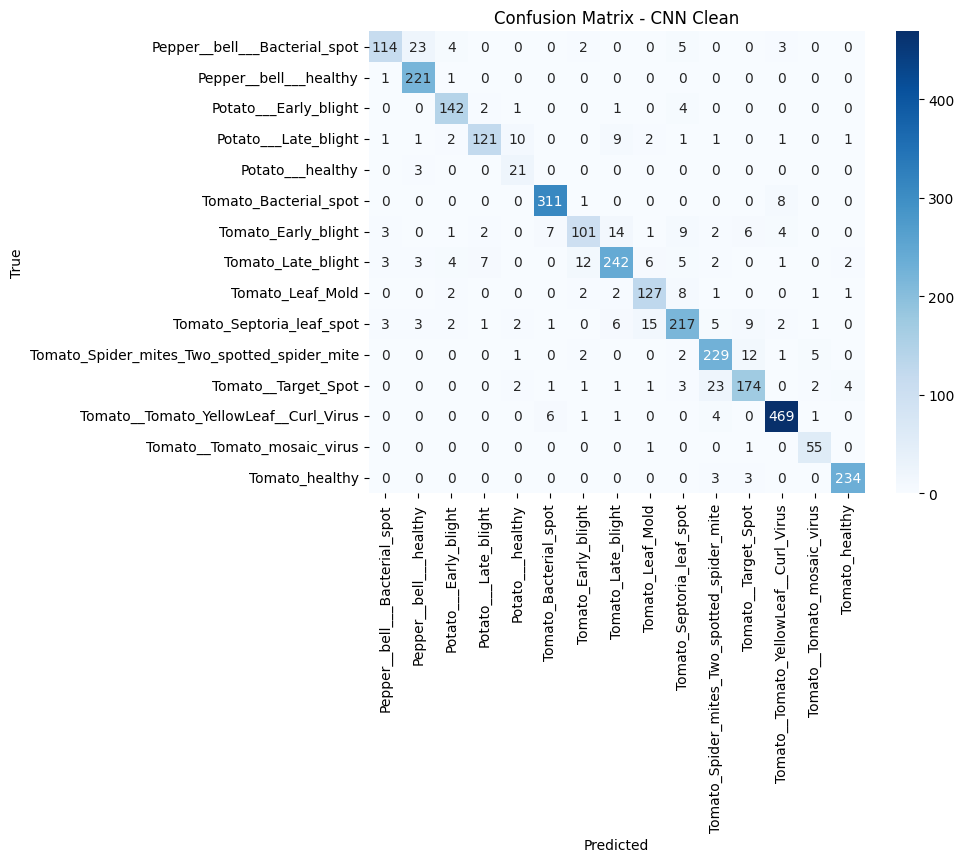

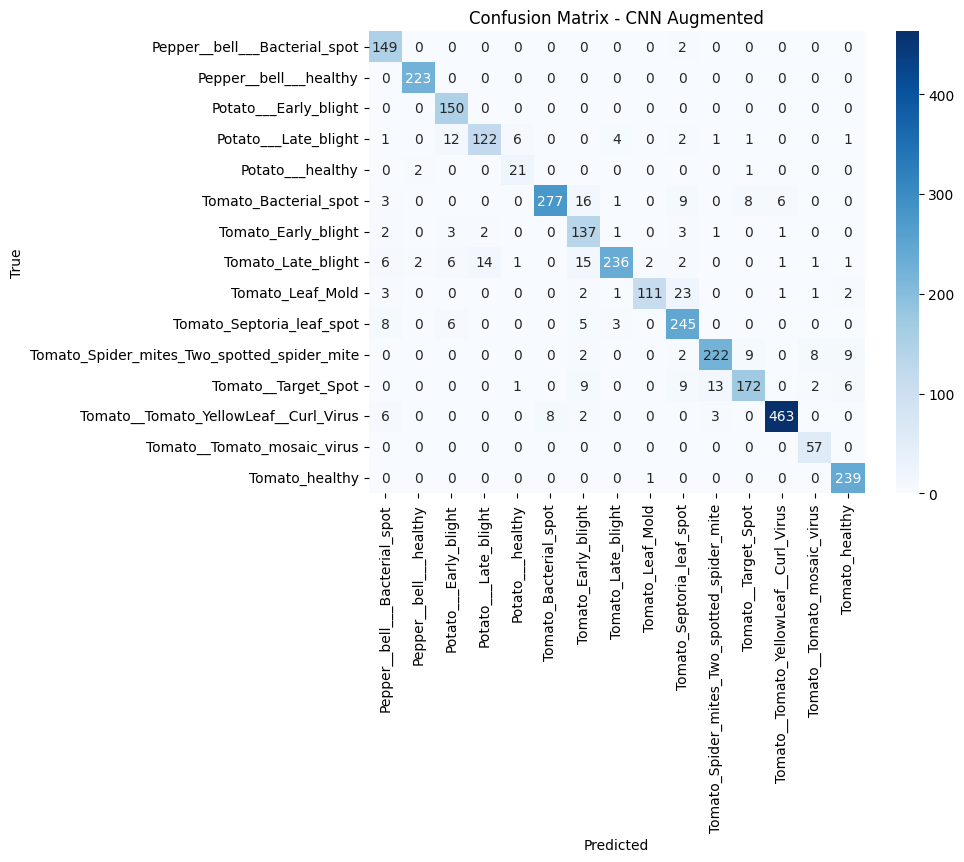

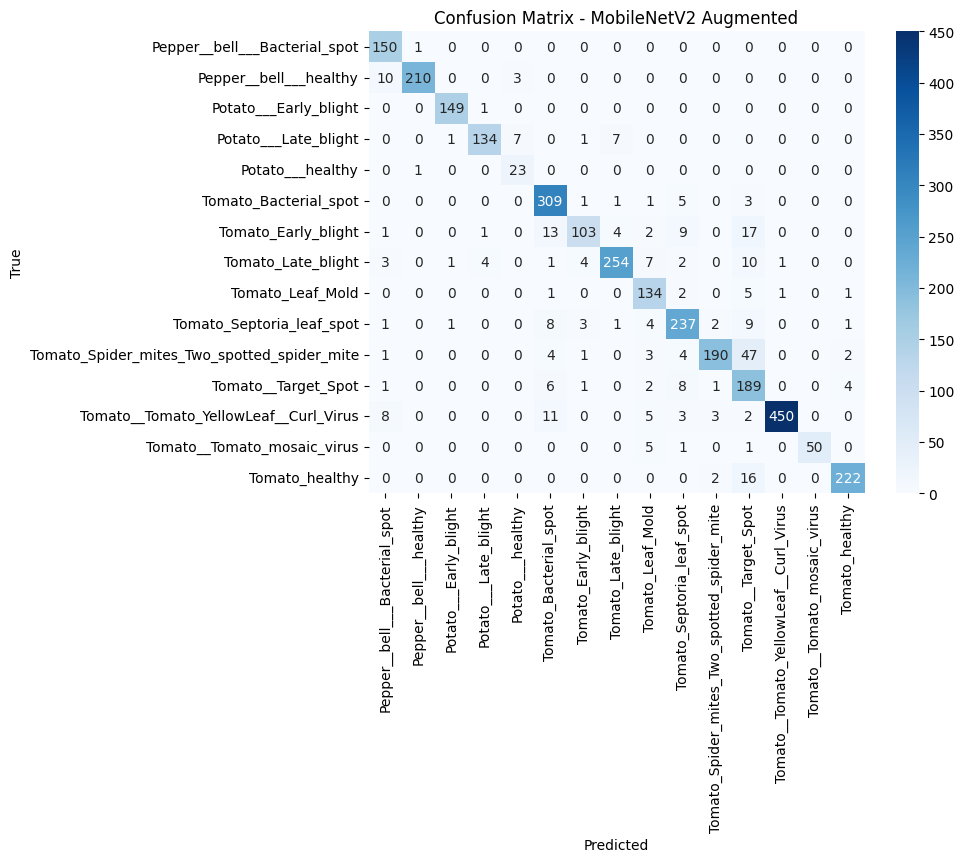

In [34]:
for name in results:
    plot_confusion_matrix(
        results[name]["confusion_matrix"],
        class_names,
        title=f"Confusion Matrix - {name}"
    )




# Discussion

This project examined how data augmentation and transfer learning affect plant disease classification performance under controlled experimental conditions.

Several important insights emerged from the experiments:

1. **Augmentation improves generalization**
   Although the augmented CNN required longer training and initially showed lower training accuracy, it achieved better validation and test performance. This indicates reduced overfitting and stronger robustness to unseen images.

2. **Transfer learning improves class balance**
   The pretrained MobileNetV2 achieved the highest macro F1-score, demonstrating better performance on minority and visually similar classes. This confirms that pretrained features are valuable when class imbalance is present.

3. **Accuracy vs robustness trade-off**
   The augmented CNN achieved the highest accuracy, while MobileNetV2 provided the most balanced performance across classes. This highlights an important design choice: whether to prioritize raw accuracy or consistent class-wise reliability.

4. **Effectiveness of imbalance handling**
   The use of weighted loss and macro-averaged F1-score successfully prevented the models from focusing only on majority classes, ensuring meaningful learning even for rare disease categories.

---

# Conclusion

This project demonstrates that both data augmentation and transfer learning significantly enhance the performance of convolutional neural networks for plant disease classification.

* A simple CNN trained on clean data provides a strong baseline but is more sensitive to class imbalance.
* Adding data augmentation improves generalization and leads to the best overall accuracy.
* Using a pretrained MobileNetV2 further improves class-balanced performance, achieving the highest macro F1-score.

Overall, the results suggest that model selection should depend on the application goal:

* For **maximum accuracy**, an augmented CNN is sufficient.
* For **fair and reliable predictions across all classes**, a pretrained model is preferable.

# Save model

In [24]:
cnn_clean.save("cnn_clean.h5")
cnn_aug.save("cnn_aug.h5")
mobilenet_aug.save("mobilenet_aug.h5")


In [25]:
import pickle

with open("history_cnn_clean.pkl", "wb") as f:
    pickle.dump(cnn_clean.history, f)

with open("history_cnn_aug.pkl", "wb") as f:
    pickle.dump(cnn_aug.history, f)

with open("history_mobilenet.pkl", "wb") as f:
    pickle.dump(mobilenet_aug.history, f)


In [40]:
import zipfile

files_to_zip = [
    "/content/cnn_clean.h5",
    "/content/cnn_aug.h5",
    "/content/mobilenet_aug.h5",
    "/content/history_cnn_clean.pkl",
    "/content/history_cnn_aug.pkl",
    "/content/history_mobilenet.pkl"
]

zip_name = "/content/all_models_and_histories.zip"

with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as zipf:
    for file in files_to_zip:
        zipf.write(file, arcname=file.split("/")[-1])

print(f"Created: {zip_name}")


Created: /content/all_models_and_histories.zip
